In [190]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [2]:
# Surpress warnings:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [3]:
# https://www.kaggle.com/datasets/fedesoriano/cirrhosis-prediction-dataset
# Cirrhosis is a late stage of scarring (fibrosis) of the liver caused by 
# many forms of liver diseases and conditions, such as hepatitis and chronic alcoholism.

In [6]:
df = pd.read_csv('cirrhosis.csv')
df.head()

,ID,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,1,400,D,D-penicillamine,21464,F,Y,Y,Y,Y,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0
1,2,4500,C,D-penicillamine,20617,F,N,Y,Y,N,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0
2,3,1012,D,D-penicillamine,25594,M,N,N,N,S,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0
3,4,1925,D,D-penicillamine,19994,F,N,Y,Y,S,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4.0
4,5,1504,CL,Placebo,13918,F,N,Y,Y,N,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,3.0


Attribute Information
1) ID: unique identifier 
2) N_Days: number of days between registration and the earlier of death, transplantation, or study analysis time in July 1986 
3) Status: status of the patient C (censored), CL (censored due to liver tx), or D (death)
4) Drug: type of drug D-penicillamine or placebo 
5) Age: age in [days]
6) Sex: M (male) or F (female)
7) Ascites: presence of ascites N (No) or Y (Yes)
8) Hepatomegaly: presence of hepatomegaly N (No) or Y (Yes)
9) Spiders: presence of spiders N (No) or Y (Yes)
10) Edema: presence of edema N (no edema and no diuretic therapy for edema), S (edema present without diuretics, or edema resolved by diuretics), or Y (edema despite diuretic therapy)
11) Bilirubin: serum bilirubin in [mg/dl]
12) Cholesterol: serum cholesterol in [mg/dl]
13) Albumin: albumin in [gm/dl]
14) Copper: urine copper in [ug/day]
15) Alk_Phos: alkaline phosphatase in [U/liter]
16) SGOT: SGOT in [U/ml]
17) Triglycerides: triglicerides in [mg/dl]
18) Platelets: platelets per cubic [ml/1000]
19) Prothrombin: prothrombin time in seconds [s]
20) Stage: histologic stage of disease (1, 2, 3, or 4)

In [90]:
df.duplicated().sum()

0

In [7]:
df['Drug'].value_counts()

D-penicillamine    158
Placebo            154
Name: Drug, dtype: int64

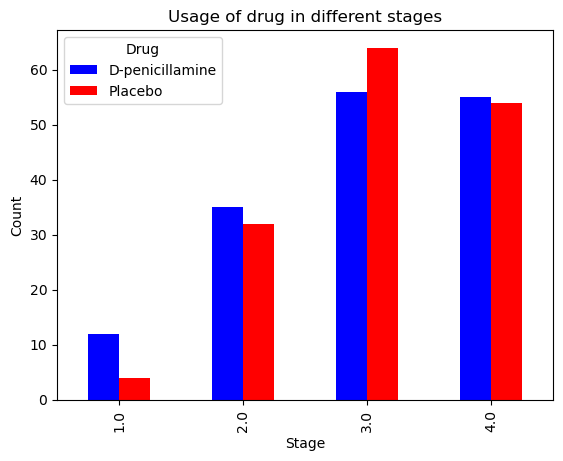

In [25]:
pd.crosstab(df['Stage'], df['Drug']).plot(kind ='bar',color='br')
plt.title('Usage of drug in different stages')
plt.ylabel('Count')
plt.xlabel('Stage')
plt.show()

<AxesSubplot:ylabel='Status'>

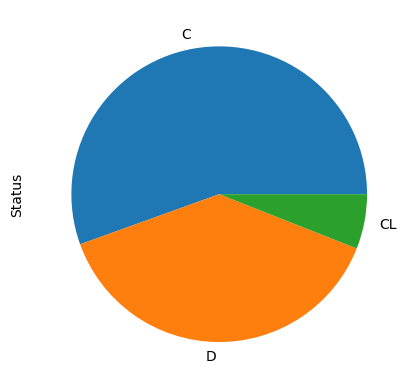

In [42]:
df.Status.value_counts().plot.pie()

Text(0.5, 1.0, 'Stage in contrast with statuses')

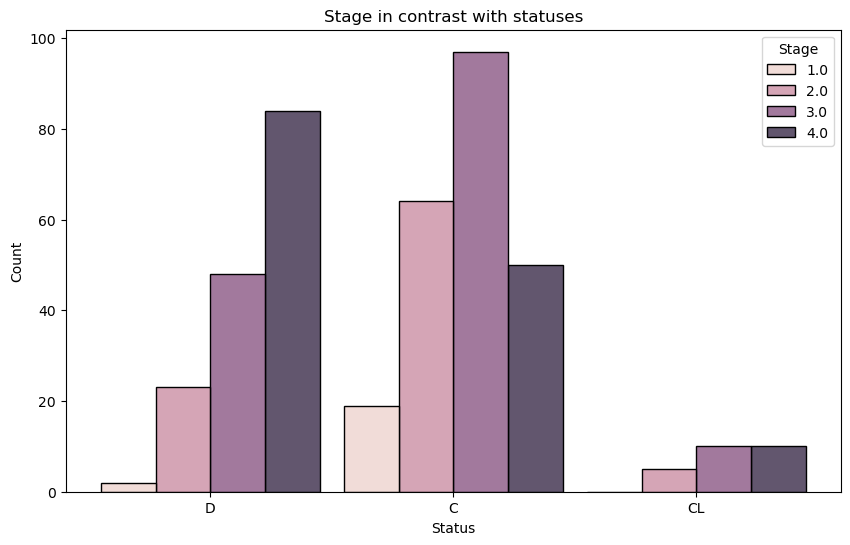

In [55]:
plt.figure(figsize=(10,6))
sns.histplot(data=df,
             x='Status',
             hue='Stage',
             multiple='dodge',
             shrink=0.9)
plt.title('Stage in contrast with statuses')

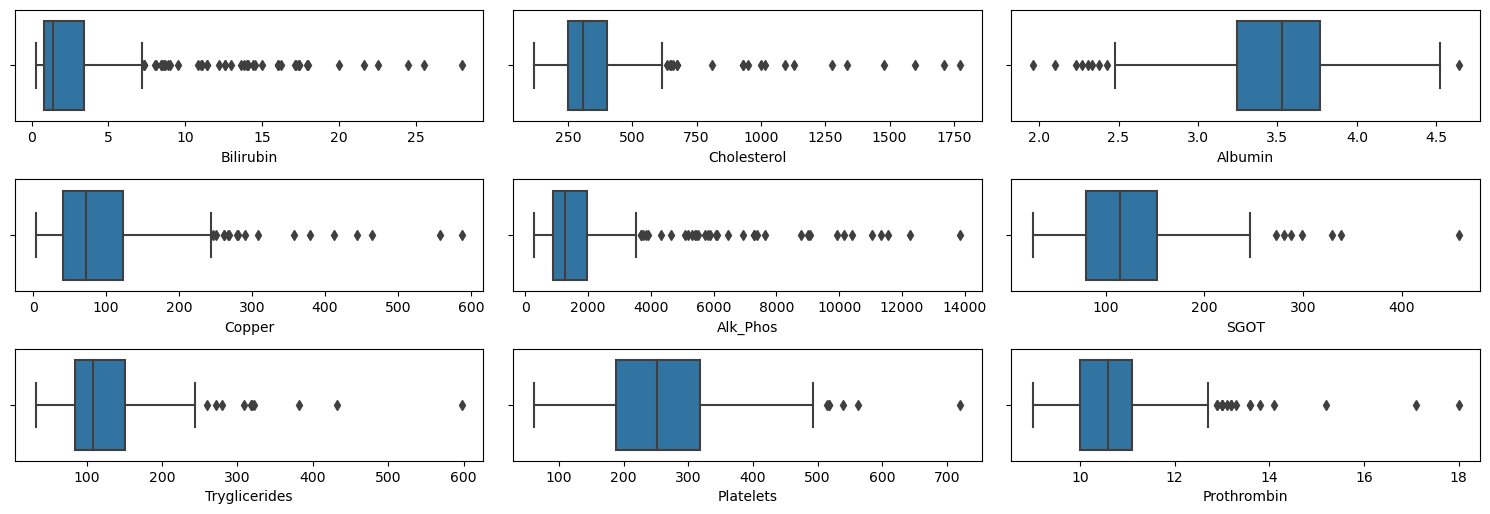

In [52]:
plt.subplots(figsize=(15,15))
features = list(df.select_dtypes(include = np.number).columns)
features.remove('ID')
features.remove('N_Days')
features.remove('Age')
features.remove('Stage')

for i, col in enumerate(features):
  plt.subplot(9,3, i + 1)
  sns.boxplot(df[col])
plt.tight_layout()
plt.show()

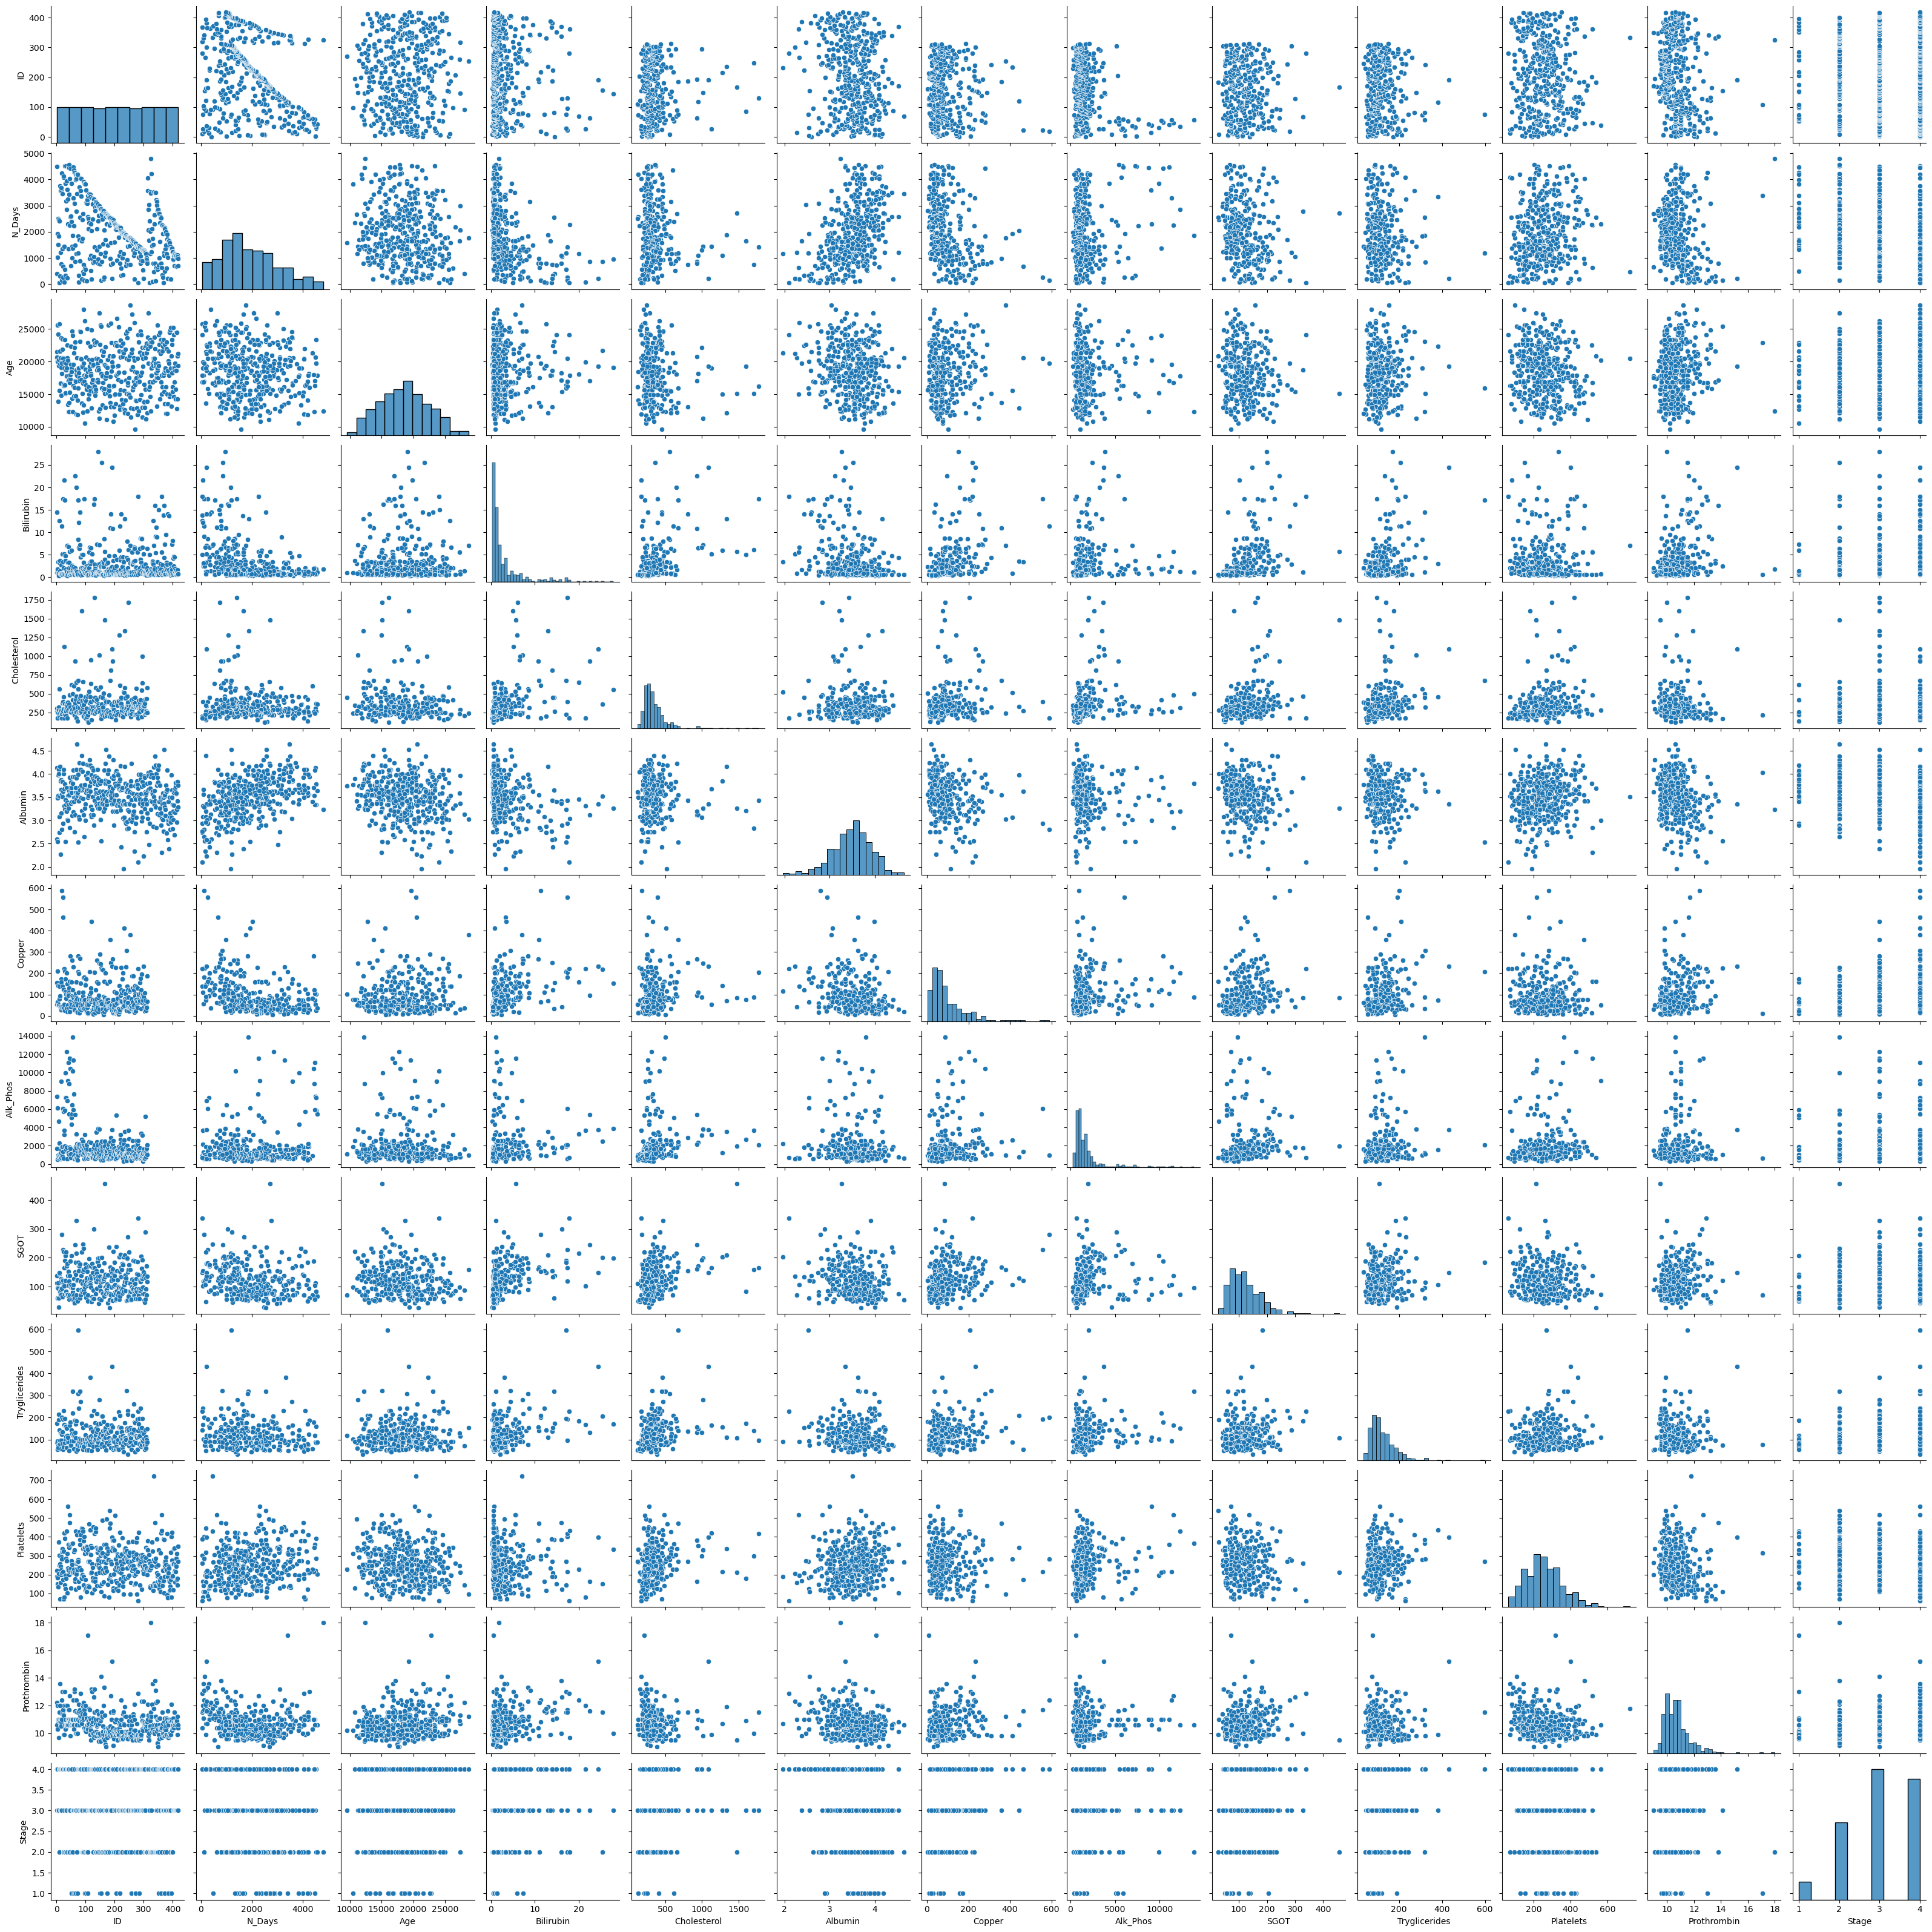

In [87]:
sns.pairplot(df)

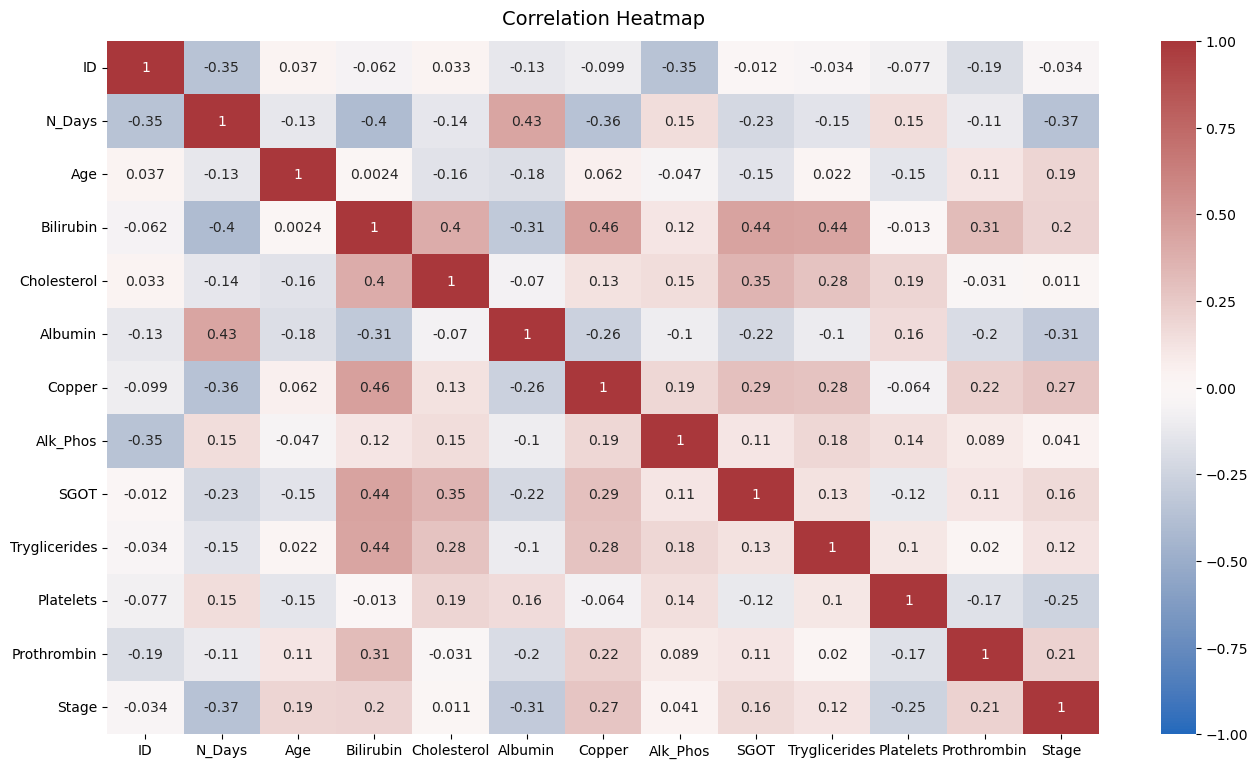

In [92]:
plt.figure(figsize=(16, 9))
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True, cmap=sns.color_palette("vlag", as_cmap=True))
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':14}, pad=12);

In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ID             418 non-null    int64  
 1   N_Days         418 non-null    int64  
 2   Status         418 non-null    object 
 3   Drug           312 non-null    object 
 4   Age            418 non-null    int64  
 5   Sex            418 non-null    object 
 6   Ascites        312 non-null    object 
 7   Hepatomegaly   312 non-null    object 
 8   Spiders        312 non-null    object 
 9   Edema          418 non-null    object 
 10  Bilirubin      418 non-null    float64
 11  Cholesterol    284 non-null    float64
 12  Albumin        418 non-null    float64
 13  Copper         310 non-null    float64
 14  Alk_Phos       312 non-null    float64
 15  SGOT           312 non-null    float64
 16  Tryglicerides  282 non-null    float64
 17  Platelets      407 non-null    float64
 18  Prothrombi

In [57]:
df.describe()

,ID,N_Days,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
count,418.000000,418.000000,418.000000,418.000000,284.000000,418.000000,310.000000,312.000000,312.000000,282.000000,407.000000,416.000000,412.000000
mean,209.500000,1917.782297,18533.351675,3.220813,369.510563,3.497440,97.648387,1982.655769,122.556346,124.702128,257.024570,10.731731,3.024272
std,120.810458,1104.672992,3815.845055,4.407506,231.944545,0.424972,85.613920,2140.388824,56.699525,65.148639,98.325585,1.022000,0.882042
min,1.000000,41.000000,9598.000000,0.300000,120.000000,1.960000,4.000000,289.000000,26.350000,33.000000,62.000000,9.000000,1.000000
25%,105.250000,1092.750000,15644.500000,0.800000,249.500000,3.242500,41.250000,871.500000,80.600000,84.250000,188.500000,10.000000,2.000000
50%,209.500000,1730.000000,18628.000000,1.400000,309.500000,3.530000,73.000000,1259.000000,114.700000,108.000000,251.000000,10.600000,3.000000
75%,313.750000,2613.500000,21272.500000,3.400000,400.000000,3.770000,123.000000,1980.000000,151.900000,151.000000,318.000000,11.100000,4.000000
max,418.000000,4795.000000,28650.000000,28.000000,1775.000000,4.640000,588.000000,13862.400000,457.250000,598.000000,721.000000,18.000000,4.000000


Prepare data

In [119]:
model_df = df.copy()
model_df = model_df.dropna().reset_index(drop = True)
model_df = model_df.drop(['ID'], axis=1)
label_encoder = LabelEncoder()
model_df['Status'] = label_encoder.fit_transform(model_df['Status']) #C = 0, CL = 1, D = 2
model_df['Sex'] = label_encoder.fit_transform(model_df['Sex']) #F = 0, M = 1
model_df['Drug'] = label_encoder.fit_transform(model_df['Drug']) #D-penicillamine = 0, Placebo = 1
model_df['Sex'] = label_encoder.fit_transform(model_df['Sex']) #F = 0, M = 1
model_df['Ascites'] = label_encoder.fit_transform(model_df['Ascites']) #Y = 1, N = 0
model_df['Hepatomegaly'] = label_encoder.fit_transform(model_df['Hepatomegaly'])#Y = 1, N = 0
model_df['Spiders'] = label_encoder.fit_transform(model_df['Spiders'])#Y = 1, N = 0
model_df['Edema'] = label_encoder.fit_transform(model_df['Edema'])#Y = 2, N = 0, S = 1
model_df.head()

,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,400,2,0,21464,0,1,1,1,2,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0
1,4500,0,0,20617,0,0,1,1,0,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0
2,1012,2,0,25594,1,0,0,0,1,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0
3,1925,2,0,19994,0,0,1,1,1,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4.0
4,1504,1,1,13918,0,0,1,1,0,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,3.0


Build a model that can predict the stage of the cirrhosis

In [120]:
#drop the status column since not clear its relevance, in this matter
# model_df = model_df.drop(['Status'], axis=1)

X = model_df.drop('Stage', axis=1)
y = model_df['Stage']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

In [122]:
log_reg = LogisticRegression(random_state=42, max_iter=500).fit(X_train, y_train)
y_pred = log_reg.predict(X_test)

In [131]:
target_names = ['Stage 1', 'Stage 2', 'Stage 3', 'Stage 4',]
print(classification_report(y_test, y_pred, target_names= target_names))

              precision    recall  f1-score   support

     Stage 1       0.00      0.00      0.00         3
     Stage 2       0.17      0.07      0.10        15
     Stage 3       0.47      0.71      0.56        28
     Stage 4       0.53      0.43      0.48        23

    accuracy                           0.45        69
   macro avg       0.29      0.30      0.28        69
weighted avg       0.40      0.45      0.41        69



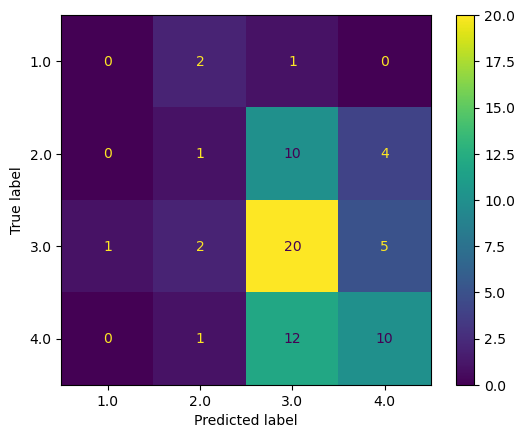

In [134]:
log_cm = confusion_matrix(y_test, y_pred, labels=log_reg.classes_)
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, 
                                  display_labels=log_reg.classes_)

log_disp.plot(values_format='')
plt.show()

In [142]:
tree = DecisionTreeClassifier(random_state=0)
# Dictionary of possible hyperparameter values
cv_params = {'max_depth':[4, 6, 8, None],
             'min_samples_leaf': [2, 5, 1],
             'min_samples_split': [2, 4, 6]
             }
scoring = {'accuracy', 'precision', 'recall', 'f1', 'roc_auc'}
tree1 = GridSearchCV(tree, cv_params, scoring=scoring, cv=4, refit='roc_auc')

tree1.fit(X_train, y_train)
y_pred = tree1.predict(X_test)

In [143]:
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

     Stage 1       0.00      0.00      0.00         3
     Stage 2       0.33      0.13      0.19        15
     Stage 3       0.42      0.75      0.54        28
     Stage 4       0.54      0.30      0.39        23

    accuracy                           0.43        69
   macro avg       0.32      0.30      0.28        69
weighted avg       0.42      0.43      0.39        69



Using deep learning

In [195]:
epochs=25
batch_size=64

#Have to execute these lines as a troubleshoot
# y = y - 1
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(4, activation='softmax')  # 4 output nodes for 4 categories, softmax activation for multi-class classification
])

model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss',
                               patience=5, 
                               restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor="val_loss",
                              factor=0.1,
                              patience=5,
                              verbose=1,
                              min_delta=0.00001)
callbacks = [early_stopping, reduce_lr]

model.fit(X_train, y_train, epochs=epochs,
          batch_size=batch_size, 
          verbose=1,
          validation_split=0.2, 
          callbacks=[callbacks])

y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=target_names))


Epoch 1/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - accuracy: 0.2250 - loss: 630.2366 - val_accuracy: 0.0714 - val_loss: 534.8796 - learning_rate: 0.0010
Epoch 2/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.1214 - loss: 455.1159 - val_accuracy: 0.2143 - val_loss: 254.8194 - learning_rate: 0.0010
Epoch 3/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.1855 - loss: 227.6694 - val_accuracy: 0.4286 - val_loss: 115.6700 - learning_rate: 0.0010
Epoch 4/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.3149 - loss: 113.0193 - val_accuracy: 0.3571 - val_loss: 211.6915 - learning_rate: 0.0010
Epoch 5/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.4170 - loss: 165.8060 - val_accuracy: 0.3095 - val_loss: 102.6022 - learning_rate: 0.0010
Epoch 6/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.3466 - loss: 100.4085 - val_accuracy: 0.4762 - val_loss: 106.0104 - learning_rate: 0.0010
Epoch 7/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.3860 - loss: 103.21

The result are from reliable. Altough with deep learning it problaly can be impoveable with the right combination of epochs and 
batch size. The reason behind this is the low number of data I believe.                                                         It is safe to say that easier to identify later stage cirhossis.        